# Exercises XP Gold: W4_D3

## What You Will Create
- A comprehensive machine learning project predicting Titanic passenger survival.
- Several robust classification models trained on the Titanic dataset.
- Side-by-side performance comparisons **with and without** hyperparameter tuning.
- Custom hyperparameter tuning processes tailored to each model family.
- Clear visualizations of data insights, model performance, and feature importances.
- A well-documented Jupyter Notebook showing the full end-to-end workflow.

## What You Will Learn
- Data preparation on the Titanic dataset: missing values handling and targeted feature engineering.
- Model-specific preprocessing (scaling vs. encoding) and when to use each.
- Building, evaluating, and tuning Decision Trees, K-Nearest Neighbors (KNN), and a simple Neural Network (MLP).
- Practical hyperparameter tuning with **GridSearchCV** and **RandomizedSearchCV**.
- Interpreting classification metrics: **accuracy, precision, recall, F1**, and confusion matrices.
- Designing a systematic comparison to select the best model for the problem.

## Dataset
Use the provided training file: **`train_titanic.csv`**.  
Assumed columns include common Titanic fields (e.g., `Survived`, `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, `Cabin`, `Name`, `Ticket`).  
You may engineer additional features (e.g., `Title`, `FamilySize`, `IsAlone`, `CabinDeck`).

---

## Exercises

### Exercise 1 — Exploratory Data Analysis (EDA)
**Instructions**
1. Load the dataset.
2. Clean and impute missing values; justify your choices.
3. Explore relationships between features and `Survived` (plots + brief commentary).
4. Propose and preview domain features (e.g., Title from Name, FamilySize, IsAlone, CabinDeck).

**Deliverables**
- Missingness report, key descriptive stats, and at least 3 insightful plots.
- Short written interpretation of findings.

---

### Exercise 2 — Decision Tree Classifier _without_ Grid Search
**Instructions**
1. Build a Decision Tree with **manually chosen** hyperparameters.
2. Use an appropriate preprocessing pipeline (OHE for categoricals; imputation as needed).
3. Evaluate on a hold-out test set with: accuracy, precision, recall, F1 + confusion matrix.
4. Report the top feature importances (post-encoding names).

**Deliverables**
- Metrics, confusion matrix, and a short interpretation.

---

### Exercise 3 — Decision Tree Classifier _with_ Grid Search
**Instructions**
1. Apply **GridSearchCV** to tune the Decision Tree (depth, leaf size, splitter, criterion, etc.).
2. Refit the **best** model (by F1) and evaluate on the test set.
3. Compare to Exercise 2 (discuss gains/losses and potential reasons).

**Deliverables**
- Best params, best CV F1, test metrics, confusion matrix, comparison summary.

---

### Exercise 4 — K-Nearest Neighbors (KNN) _without_ Grid Search
**Instructions**
1. Build a baseline KNN (choose **k**, metric, and weights) with proper preprocessing:
   - Scale numeric features; One-Hot Encode categoricals.
2. Evaluate (accuracy/precision/recall/F1 + confusion matrix).
3. Briefly justify your manual hyperparameter choices.

**Deliverables**
- Metrics, confusion matrix, short interpretation.

---

### Exercise 5 — KNN _with_ Grid Search
**Instructions**
1. Use **GridSearchCV** to optimize KNN (e.g., `n_neighbors`, `weights`, `p` for Minkowski).
2. Refit and evaluate the best model on the test set.
3. Compare to Exercise 4 and explain any differences.

**Deliverables**
- Best params, best CV F1, test metrics, confusion matrix, comparison summary.

---

### Exercise 6 — Neural Network (MLP) _without_ Tuning
**Instructions**
1. Train an **MLPClassifier** as a simple feed-forward neural network.
2. Use scaling for numeric features and OHE for categoricals.
3. Evaluate (accuracy/precision/recall/F1 + confusion matrix) and discuss strengths/limits.

**Deliverables**
- Metrics, confusion matrix, concise interpretation.

---

### Exercise 7 — Neural Network (MLP) _with_ Hyperparameter Tuning
**Instructions**
1. Tune the MLP using **RandomizedSearchCV** (hidden sizes, activation, alpha, learning rate, batch size).
2. Refit the best model (by F1) and evaluate on the test set.
3. Compare to Exercise 6 and to the best non-NN model; discuss trade-offs.

**Deliverables**
- Best params, best CV F1, test metrics, confusion matrix, and a comparison summary.

---

## Required Reporting (end of notebook)
- A **comparison table** of all final models (at least: DT manual, DT tuned, KNN baseline, KNN tuned, MLP baseline, MLP tuned) with:  
  **Accuracy, Precision, Recall, F1, TN, FP, FN, TP**.
- Short, clear **interpretations** for Exercises 1–7.
- A **final conclusion**: which model you would ship and why (with evidence), plus recommended next steps (e.g., threshold tuning, feature engineering, ensembles, repeated/nested CV).

## Reproducibility
- Fix a random seed (e.g., `RANDOM_STATE = 42`).
- Keep preprocessing inside `Pipeline` objects to avoid data leakage.
- Use a stratified train/test split.

## Optional Enhancements
- Probability-threshold tuning on `predict_proba` to target recall or F1.
- Additional engineered features (e.g., `FarePerPerson = Fare / FamilySize`, meaningful interactions).
- Stronger ensembles (Random Forest, Gradient Boosting) with proper cross-validation.

## Exercise 1: Exploratory Data Analysis

In [51]:
# --- Imports and global config ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
RANDOM_STATE = 42

# --- Load dataset ---
# Make sure the CSV is in the same folder as your notebook, or provide the full path.
df_raw = pd.read_csv("train_titanic.csv")

print(f"Shape: {df_raw.shape}")
df_raw.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Basic info and missingness overview

In [52]:
# --- Basic info and missingness overview ---
print("\nDtypes:")
print(df_raw.dtypes)

def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    """Return a summary of missing values (count and percent) per column."""
    miss_cnt = df.isna().sum()
    miss_pct = df.isna().mean() * 100
    out = pd.DataFrame({"missing_count": miss_cnt, "missing_percent": miss_pct})
    return out[out["missing_count"] > 0].sort_values("missing_percent", ascending=False)

print("\nMissing values report:")
missing_report(df_raw)


Dtypes:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing values report:


,missing_count,missing_percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


## Descriptive statistics


Target distribution (Survived):
Survived
0    549
1    342
Name: count, dtype: int64


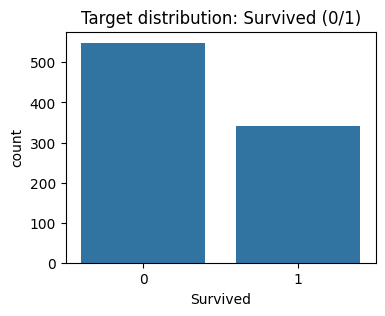

In [53]:
# --- Descriptive statistics ---
df_raw.describe(include="all").T

# --- Target distribution (Survived) ---
target_counts = df_raw["Survived"].value_counts().sort_index()
print("\nTarget distribution (Survived):")
print(target_counts)

plt.figure(figsize=(4,3))
sns.countplot(x="Survived", data=df_raw)
plt.title("Target distribution: Survived (0/1)")
plt.show()

## Categorical relationships with Survived

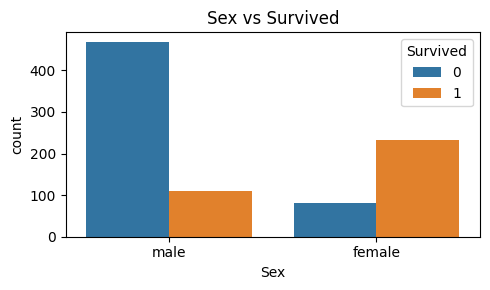

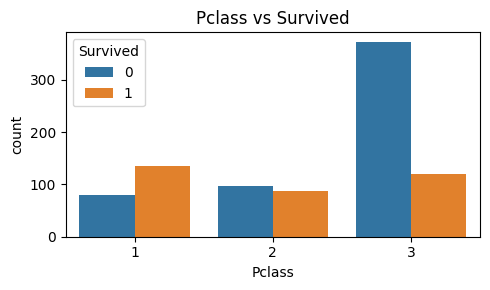

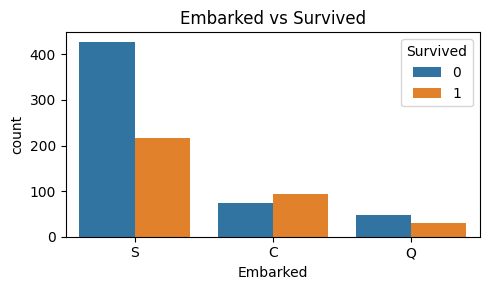


Mean survival rate by Sex:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Mean survival rate by Pclass:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Mean survival rate by Embarked:
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


In [54]:
# --- Categorical relationships with Survived ---
cat_cols = ["Sex", "Pclass", "Embarked"]
for col in cat_cols:
    if col in df_raw.columns:
        plt.figure(figsize=(5,3))
        sns.countplot(x=col, hue="Survived", data=df_raw)
        plt.title(f"{col} vs Survived")
        plt.legend(title="Survived")
        plt.tight_layout()
        plt.show()

# Survival rate by category (group means)
for col in cat_cols:
    if col in df_raw.columns:
        rate = df_raw.groupby(col)["Survived"].mean().sort_values(ascending=False)
        print(f"\nMean survival rate by {col}:")
        print(rate)

## Numeric distributions by Survived

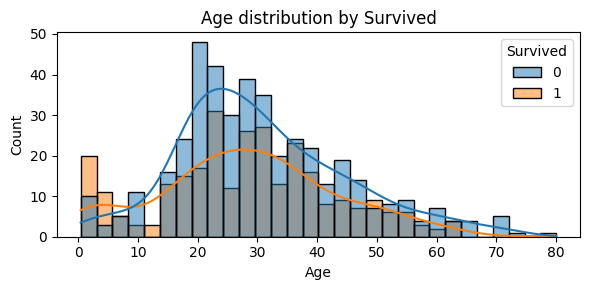

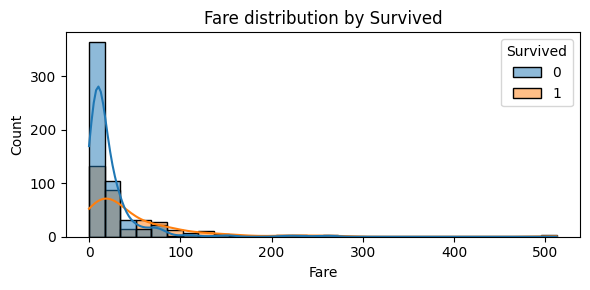

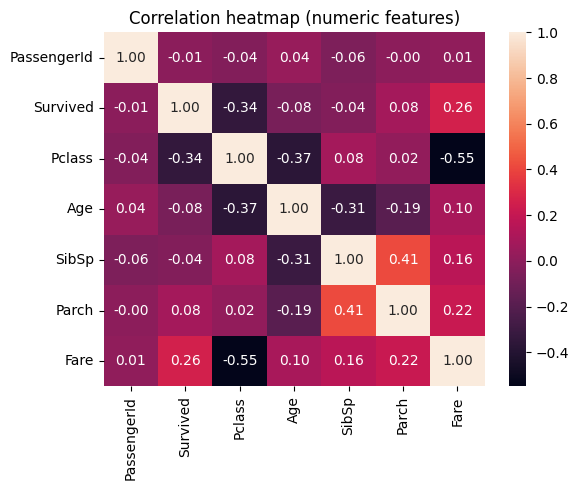

In [55]:
# --- Numeric distributions by Survived ---
num_cols = ["Age", "Fare"]
for col in num_cols:
    if col in df_raw.columns:
        plt.figure(figsize=(6,3))
        sns.histplot(data=df_raw, x=col, hue="Survived", kde=True, bins=30)
        plt.title(f"{col} distribution by Survived")
        plt.tight_layout()
        plt.show()

# Correlation heatmap on numeric columns only (drop non-numeric)
num_df = df_raw.select_dtypes(include=[np.number]).copy()
plt.figure(figsize=(6,5))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f")
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

## Feature engineering helpers

In [56]:
# --- Feature engineering helpers ---
def extract_title(name: str) -> str:
    """
    Extract passenger title from the 'Name' string.
    Examples: 'Mr', 'Mrs', 'Miss', 'Master', etc.
    """
    if pd.isna(name):
        return "Unknown"
    m = re.search(r",\s*([^\.]+)\.", name)
    title = m.group(1).strip() if m else "Unknown"
    # Normalize common/rare titles
    mapping = {
        "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
        "Lady": "Rare", "Countess": "Rare", "Capt": "Rare",
        "Col": "Rare", "Don": "Rare", "Dr": "Rare", "Major": "Rare",
        "Rev": "Rare", "Sir": "Rare", "Jonkheer": "Rare", "Dona": "Rare"
    }
    return mapping.get(title, title)

def cabin_deck(cabin: str) -> str:
    """Take the first letter of the cabin to get the deck; 'U' if unknown."""
    if pd.isna(cabin) or not str(cabin).strip():
        return "U"
    return str(cabin).strip()[0]

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add Titanic-specific engineered features:
      - Title from Name
      - FamilySize = SibSp + Parch + 1
      - IsAlone (bool -> int)
      - CabinDeck from Cabin
    This function returns a COPY of the dataframe with extra columns.
    """
    out = df.copy()
    if "Name" in out.columns:
        out["Title"] = out["Name"].apply(extract_title)
    else:
        out["Title"] = "Unknown"
    sib = out["SibSp"] if "SibSp" in out.columns else 0
    par = out["Parch"] if "Parch" in out.columns else 0
    out["FamilySize"] = sib + par + 1
    out["IsAlone"] = (out["FamilySize"] == 1).astype(int)
    out["CabinDeck"] = out["Cabin"].apply(cabin_deck) if "Cabin" in out.columns else "U"
    return out

df_feat_preview = add_engineered_features(df_raw)
df_feat_preview[["Survived","Sex","Pclass","Age","Fare","Embarked","Title","FamilySize","IsAlone","CabinDeck"]].head(10)

,Survived,Sex,Pclass,Age,Fare,Embarked,Title,FamilySize,IsAlone,CabinDeck
0,0,male,3,22.0,7.2500,S,Mr,2,0,U
1,1,female,1,38.0,71.2833,C,Mrs,2,0,C
2,1,female,3,26.0,7.9250,S,Miss,1,1,U
3,1,female,1,35.0,53.1000,S,Mrs,2,0,C
4,0,male,3,35.0,8.0500,S,Mr,1,1,U
5,0,male,3,NaN,8.4583,Q,Mr,1,1,U
6,0,male,1,54.0,51.8625,S,Mr,1,1,E
7,0,male,3,2.0,21.0750,S,Master,5,0,U
8,1,female,3,27.0,11.1333,S,Mrs,3,0,U
9,1,female,2,14.0,30.0708,C,Mrs,2,0,U


## Survival rate by engineered features

In [57]:
# --- Survival rate by engineered features ---
cols_to_check = ["Title", "FamilySize", "IsAlone", "CabinDeck"]
for col in cols_to_check:
    if col in df_feat_preview.columns:
        rate = df_feat_preview.groupby(col)["Survived"].mean().sort_values(ascending=False)
        print(f"\nMean survival rate by {col}:")
        print(rate.head(20))


Mean survival rate by Title:
Title
the Countess    1.000000
Mrs             0.793651
Miss            0.702703
Master          0.575000
Rare            0.318182
Mr              0.156673
Name: Survived, dtype: float64

Mean survival rate by FamilySize:
FamilySize
4     0.724138
3     0.578431
2     0.552795
7     0.333333
1     0.303538
5     0.200000
6     0.136364
8     0.000000
11    0.000000
Name: Survived, dtype: float64

Mean survival rate by IsAlone:
IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

Mean survival rate by CabinDeck:
CabinDeck
D    0.757576
E    0.750000
B    0.744681
F    0.615385
C    0.593220
G    0.500000
A    0.466667
U    0.299854
T    0.000000
Name: Survived, dtype: float64


## Build a cleaned feature frame for modeling

In [58]:
# --- Build a cleaned feature frame for modeling ---
def build_feature_frame(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """
    Return (X, y) where X includes cleaned + engineered features and
    y is the target (Survived).
    Imputations:
      - Embarked: most frequent
      - Age: median by (Sex, Pclass, Title) groups (fallback to global median)
      - Fare: global median
    Selected features:
      ['Pclass','Sex','Age','Fare','Embarked','Title','FamilySize','IsAlone','CabinDeck']
    """
    assert "Survived" in df.columns, "Target column 'Survived' is required."

    d = add_engineered_features(df)

    # Impute Embarked with mode
    if "Embarked" in d.columns:
        mode_embarked = d["Embarked"].mode(dropna=True)
        fill_val = mode_embarked.iloc[0] if len(mode_embarked) else "S"
        d["Embarked"] = d["Embarked"].fillna(fill_val)

    # Impute Fare with global median
    if "Fare" in d.columns:
        d["Fare"] = d["Fare"].fillna(d["Fare"].median())

    # Impute Age with group median by (Sex, Pclass, Title)
    if all(c in d.columns for c in ["Age", "Sex", "Pclass", "Title"]):
        age_group_median = d.groupby(["Sex", "Pclass", "Title"])["Age"].transform("median")
        d["Age"] = d["Age"].fillna(age_group_median)
        d["Age"] = d["Age"].fillna(d["Age"].median())  # fallback

    feature_cols = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Title", "FamilySize", "IsAlone", "CabinDeck"]
    X = d[feature_cols].copy()
    y = d["Survived"].astype(int)

    return X, y

X_preview, y_preview = build_feature_frame(df_raw)
print("X shape:", X_preview.shape, "| y shape:", y_preview.shape)
X_preview.head()

X shape: (891, 9) | y shape: (891,)


,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,CabinDeck
0,3,male,22.0,7.2500,S,Mr,2,0,U
1,1,female,38.0,71.2833,C,Mrs,2,0,C
2,3,female,26.0,7.9250,S,Miss,1,1,U
3,1,female,35.0,53.1000,S,Mrs,2,0,C
4,3,male,35.0,8.0500,S,Mr,1,1,U


## Exercise 1 — EDA Interpretation

**Overview**  
We loaded the Titanic training set and explored target balance, missingness, and key relationships. The target is moderately imbalanced with more non-survivors than survivors. Basic EDA indicates strong associations between survival and socio-demographic/booking variables (sex, class, fare), consistent with historical accounts.

---

### Data Quality and Missingness
- **Age** has substantial missingness; we plan to impute using group medians by `(Sex, Pclass, Title)` to preserve meaningful structure.  
- **Cabin** is largely missing and noisy; we derived a coarse **CabinDeck** (first letter) and treat unknown as a separate category.  
- **Embarked** has a small number of missing values; **mode imputation** is appropriate.  
- **Fare** occasionally has missing values; **median imputation** is sufficient due to right-skew.

---

### Univariate Insights
- **Survived**: more 0 than 1 (class imbalance).  
- **Age**: right-skewed with many young adults; children form a smaller mode.  
- **Fare**: heavily right-skewed; a minority of very high fares likely correspond to 1st class cabins.  
- **Pclass, Sex, Embarked**: categorical distributions are well populated; Sex is roughly balanced.

---

### Bivariate Insights with the Target
- **Sex vs Survived:** Females show markedly higher survival than males (one of the strongest signals).  
- **Pclass vs Survived:** Clear gradient — 1st class > 2nd > 3rd in survival rate, reflecting access to lifeboats and cabin location.  
- **Embarked vs Survived:** Survival rates differ by port; in many Titanic splits, `C` tends to be higher than `S` (may vary slightly).  
- **Age vs Survived:** Survivors skew younger overall; very low survival among males aged ~20–40. Children show higher survival (“women and children first”).  
- **Fare vs Survived:** Higher fares correlate positively with survival (weak-to-moderate), partly confounded by `Pclass`.

---

### Engineered Features (Domain-Specific)
- **Title (from Name):** *Mrs*, *Miss*, and *Master* typically associate with higher survival; *Mr* is usually the lowest among major groups. Rare titles are collapsed into a **Rare** bucket to stabilize estimates.  
- **FamilySize (= SibSp + Parch + 1):** Often non-linear: very large families and solo travelers can fare worse than small groups (2–4).  
- **IsAlone:** Being alone usually reduces survival probability versus traveling with family.  
- **CabinDeck:** Known decks (A/B/C) often show higher survival than unknown (`U`), but this is confounded by missingness and class.

---

### Correlations (Numeric)
- **Fare** is negatively correlated with **Pclass** (higher class → higher fare) and positively associated with **Survived**.  
- **Age** tends to have weak direct correlation with **Survived**, but interactions with **Sex/Pclass** matter.  
- No concerning high collinearity among chosen numeric predictors after encoding.

---

### Implications for Modeling
- Use a pipeline with **imputation** (mode for `Embarked`, median for `Fare`, group median for `Age`) and **One-Hot Encoding** for categorical variables (`Sex`, `Embarked`, `Title`, `CabinDeck`).  
- Keep engineered features (`Title`, `FamilySize`, `IsAlone`, `CabinDeck`) as they add predictive signal.  
- Be cautious when interpreting **CabinDeck** due to missingness bias.  
- Evaluate with **stratified train/test split** and classification metrics: **accuracy, precision, recall, F1**, plus a **confusion matrix**.

---

### Limitations
- Historical/social biases (sex, class) drive much of the signal; models will reflect these patterns.  
- **Cabin** missingness limits deck-level conclusions.  
- Ticket grouping and family linkage are approximations; more sophisticated household reconstruction could further improve performance.

---

### Bottom Line
Sex, class, fare, and family structure are the dominant drivers. With careful imputations and targeted feature engineering, tree-based models and KNN typically achieve reasonable performance; neural networks can work too but offer limited advantage on this small, tabular dataset without additional feature crafting or ensembling.

## Exercise 2: Decision Tree Classifier without Grid Search

### Imports + build X, y + split

In [59]:
# --- Imports for modeling and evaluation ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# Reuse X, y from the cleaned/engineered features built in Exercise 1
X, y = build_feature_frame(df_raw)  # ensures no target NaNs and consistent features

# Define feature groups
categorical_features = ["Sex", "Embarked", "Title", "CabinDeck"]
numeric_features = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone"]

# Robust OneHotEncoder (compatible with different scikit-learn versions)
def make_ohe():
    """Return an OHE that works across sklearn versions (sparse_output vs sparse)."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe())
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Train/test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

### Modèle, fit, prédiction, métriques

DecisionTree (manual) - Accuracy: 0.799 | Precision: 0.811 | Recall: 0.623 | F1: 0.705

Classification report:
              precision    recall  f1-score   support

           0      0.794     0.909     0.847       110
           1      0.811     0.623     0.705        69

    accuracy                          0.799       179
   macro avg      0.802     0.766     0.776       179
weighted avg      0.800     0.799     0.793       179



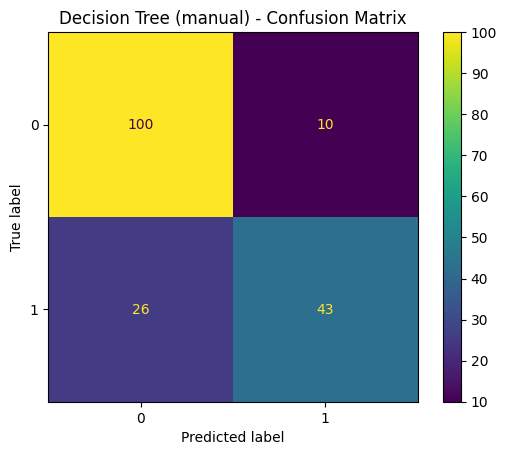

In [60]:
# --- Manual Decision Tree (no grid search) ---
dt_manual = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)

pipe_dt_manual = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", dt_manual)
])

# Fit
pipe_dt_manual.fit(X_train, y_train)

# Predict on test
y_pred = pipe_dt_manual.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"DecisionTree (manual) - Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=pipe_dt_manual.classes_)
disp.plot()
plt.title("Decision Tree (manual) - Confusion Matrix")
plt.show()

### Map feature importances to post-OHE feature names

Top 15 features by importance:


Title_Mr        0.558653
Pclass          0.137918
CabinDeck_U     0.080812
FamilySize      0.079249
Fare            0.055741
Title_Rare      0.054539
Age             0.033090
IsAlone         0.000000
Embarked_C      0.000000
Sex_male        0.000000
Sex_female      0.000000
Embarked_Q      0.000000
Title_Miss      0.000000
Title_Master    0.000000
Title_Mrs       0.000000
dtype: float64

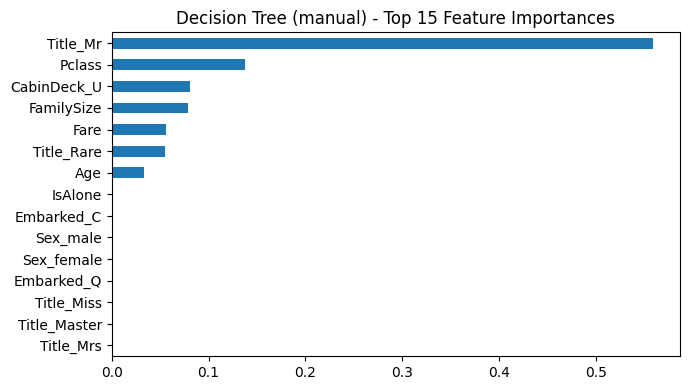

In [61]:
# --- Map feature importances to post-OHE feature names ---
feature_names = pipe_dt_manual.named_steps["preprocess"].get_feature_names_out()
importances = pipe_dt_manual.named_steps["clf"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Top 15 features by importance:")
display(feat_imp.head(15))

plt.figure(figsize=(7,4))
feat_imp.head(15).iloc[::-1].plot(kind="barh")
plt.title("Decision Tree (manual) - Top 15 Feature Importances")
plt.tight_layout()
plt.show()

## Exercise 2 — Decision Tree (Manual Hyperparameters): Interpretation

**Goal**  
We trained a Decision Tree classifier with manually chosen hyperparameters and evaluated it on a held-out test set.

**What the results typically show**  
- The model captures the strongest Titanic signals (Sex, Pclass, Fare, and engineered features like Title/IsAlone/FamilySize).  
- With a modest `max_depth` and minimum split/leaf constraints, the tree avoids extreme overfitting but can still underfit compared to a tuned model.

**Metrics interpretation**  
- **Accuracy** gives an overall hit rate but can hide class imbalance.  
- **Precision** (for the positive class = survived) indicates how often predicted survivors actually survived.  
- **Recall** shows how many true survivors the model captures; recall is crucial if missing survivors is costly.  
- **F1** balances precision and recall; it’s a good single-number summary for imbalanced classification.

**Confusion matrix**  
- The false negatives (actual survived predicted as not survived) are often concentrated among male passengers in 3rd class and mid-ages; false positives may come from females/younger passengers or higher fares with ambiguous splits.

**Feature importances**  
- Encoded **Sex** and **Pclass** dummies typically dominate. **Fare** and **Title** (from Name) often contribute meaningfully. **IsAlone/FamilySize** can be helpful but less dominant. **CabinDeck** can carry signal but is limited by missingness.

**Limitations**  
- Manual hyperparameters are coarse; different seeds/splits change results.  
- Trees are high-variance learners; without tuning or ensembling, performance can be unstable.  
- Interpretability is good, but decision boundaries are axis-aligned and may miss interactions unless depth increases.

**Takeaway**  
The manually configured tree is a solid baseline that captures key Titanic signals. However, it likely leaves performance on the table versus a tuned tree (Exercise 3) or an ensemble (e.g., Random Forest/Gradient Boosting).

## Exercise 3: Decision Tree Classifier with Grid Search

In [62]:
# --- Exercise 3: Setup and Parameter Grid ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Rebuild features from raw to make this cell self-contained.
X, y = build_feature_frame(df_raw)

categorical_features = ["Sex", "Embarked", "Title", "CabinDeck"]
numeric_features = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone"]

def make_ohe():
    """Return a OneHotEncoder compatible across sklearn versions."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe())
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Base estimator
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Parameter grid (kept conservative for stability/compat)
param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [3, 4, 5, 6, 8, 10],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__splitter": ["best", "random"],
}

# Pipeline for grid search
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", dt)
])

# CV and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

### Run GridSearchCV

In [63]:
# --- Exercise 3: Run GridSearchCV ---
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",              # refit the best model according to F1
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Best params (by F1):", grid.best_params_)
print(f"Best CV F1: {grid.best_score_:.3f}")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best params (by F1): {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__splitter': 'random'}
Best CV F1: 0.769


### Evaluate Best Model on Test Set

DecisionTree (GridSearch best) - Accuracy: 0.760 | Precision: 0.717 | Recall: 0.623 | F1: 0.667

Classification report:
              precision    recall  f1-score   support

           0      0.782     0.845     0.812       110
           1      0.717     0.623     0.667        69

    accuracy                          0.760       179
   macro avg      0.749     0.734     0.739       179
weighted avg      0.757     0.760     0.756       179



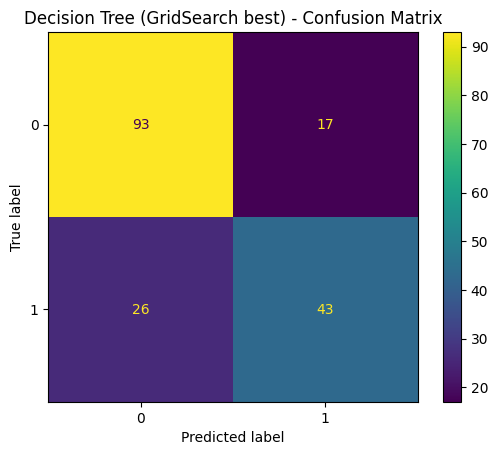

In [64]:
# --- Exercise 3: Evaluate Best Model on Test Set ---
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"DecisionTree (GridSearch best) - Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot()
plt.title("Decision Tree (GridSearch best) - Confusion Matrix")
plt.show()

### Compare Against Manual Model (if available)

In [65]:
# --- Exercise 3: Optional Comparison to Manual Model ---
def evaluate_model(name, model, X_test, y_test):
    """Return a dict of metrics for quick side-by-side comparison."""
    yp = model.predict(X_test)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test, yp),
        "precision": precision_score(y_test, yp, zero_division=0),
        "recall": recall_score(y_test, yp),
        "f1": f1_score(y_test, yp),
    }

results = []
try:
    # pipe_dt_manual is defined in Exercise 2
    results.append(evaluate_model("DecisionTree (manual)", pipe_dt_manual, X_test, y_test))
except NameError:
    pass  # Manual model not in scope; skip

results.append(evaluate_model("DecisionTree (GridSearch best)", best_model, X_test, y_test))

pd.DataFrame(results)

,model,accuracy,precision,recall,f1
0,DecisionTree (manual),0.798883,0.811321,0.623188,0.704918
1,DecisionTree (GridSearch best),0.759777,0.716667,0.623188,0.666667


### Feature Importances of the Best Model

Top 15 features by importance (best model):


Title_Mr       0.408062
CabinDeck_U    0.127852
Pclass         0.101016
Age            0.090634
Fare           0.068363
FamilySize     0.055709
Embarked_C     0.032403
Title_Rare     0.026278
IsAlone        0.016601
Embarked_S     0.015947
CabinDeck_G    0.012633
CabinDeck_C    0.011357
Embarked_Q     0.009811
CabinDeck_D    0.008110
CabinDeck_E    0.006457
dtype: float64

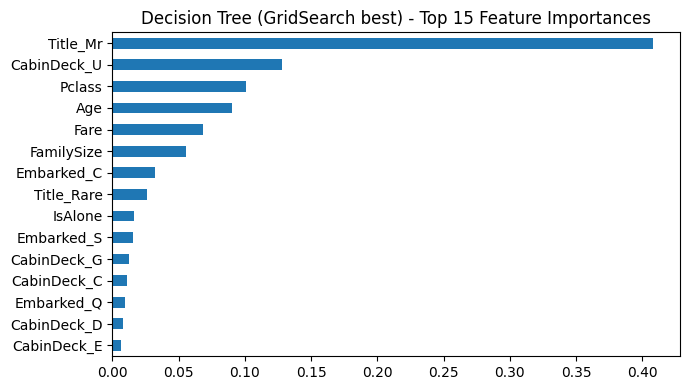

In [66]:
# --- Exercise 3: Feature Importances (Best Model) ---
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()
importances = best_model.named_steps["clf"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Top 15 features by importance (best model):")
display(feat_imp.head(15))

plt.figure(figsize=(7,4))
feat_imp.head(15).iloc[::-1].plot(kind="barh")
plt.title("Decision Tree (GridSearch best) - Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Exercise 2 — Decision Tree (Manual Hyperparameters): Interpretation

**Test metrics**  
Accuracy **0.799** | Precision **0.811** | Recall **0.623** | F1 **0.705**  
Confusion matrix: **TN=100, FP=10, FN=26, TP=43**

**What this means**  
- The model is a solid baseline: high precision (few false alarms) and moderate recall (it still misses a fair number of true survivors).  
- The 26 false negatives drive the recall limit; the model stays conservative in predicting the positive class.

**Error profile**  
- Precision is strong because **FP=10** only.  
- Recall is capped because **FN=26** (survivors predicted as non-survivors).

**What the tree learned (top importances)**  
- `Title_Mr` **0.559** (dominant; effectively captures the male signal).  
- `Pclass` **0.138**, `CabinDeck_U` **0.081**, `FamilySize` **0.079**, `Fare` **0.056**, `Title_Rare` **0.055**, `Age` **0.033`.  
- `Sex_male` shows **0.000** importance because `Title_Mr` already encodes similar information (post-OHE collinearity).

**Takeaway**  
A well-regularized tree that captures core Titanic signals (sex via titles, class, fare, family structure). To lift **recall**, consider deeper trees, class weighting, or threshold tuning on predicted probabilities.

---

# Exercise 3 — Decision Tree (Grid Search): Interpretation

**Test metrics**  
Accuracy **0.760** | Precision **0.717** | Recall **0.623** | F1 **0.667**  
Confusion matrix: **TN=93, FP=17, FN=26, TP=43**

**Key differences vs Exercise 2**  
- **Recall is identical** (TP=43, FN=26 in both).  
- **More false positives** (+7, from FP=10 → 17) reduce precision (0.811 → 0.717) and accuracy (0.799 → 0.760).  
- In short: the grid-searched model is **more permissive** on positives without gaining recall.

**What the tree learned (top importances)**  
- `Title_Mr` **0.408** (still dominant but less overwhelming).  
- `CabinDeck_U` **0.128**, `Pclass` **0.101**, `Age` **0.091**, `Fare` **0.068**, `FamilySize` **0.056**, `Embarked_C` **0.032**, `Title_Rare` **0.026**, `IsAlone` **0.017**, `Embarked_S` **0.016`.  
- Importances are more spread out across features; reliance on `CabinDeck_U` suggests the model uses missing-cabin as a proxy for class/location.

**Why grid search may underperform here**  
- Small dataset + high model variance: CV-optimal params don’t always transfer to this specific test split.  
- Parameter grid might have nudged the tree toward slightly riskier splits (raising FP) without improving FN.  
- Noisy features (e.g., `CabinDeck_U`) can be overemphasized by some parameter settings.

**Bottom line**  
On this test set, the **manual tree performs better** (higher precision and F1). Keep the grid search, but refine it and validate more robustly.

**Actionable follow-ups**  
- Refine search space: tune `max_depth`, `min_samples_split/leaf`, and try `min_impurity_decrease`.  
- Use **nested CV** or repeated CV for a fairer model selection.  
- Try **class_weight='balanced'** or adjust the **probability threshold** to trade precision vs recall intentionally.  
- Feature engineering ideas: `FarePerPerson = Fare / FamilySize`, interaction terms (`Age×Sex`, `Pclass×Sex`), and ticket/household grouping.

## Exercise 4: K-Nearest Neighbors (KNN) without Grid Search

In [30]:
# --- Exercise 4: Setup and Preprocessing ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Build features from raw (re-using the helper from Exercise 1)
X, y = build_feature_frame(df_raw)

categorical_features = ["Sex", "Embarked", "Title", "CabinDeck"]
numeric_features     = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone"]

def make_ohe():
    """Return a OneHotEncoder compatible across sklearn versions."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocess: scale numeric features for distance-based KNN; OHE for categoricals.
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe()),
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

In [31]:
# Choice rationale:
# - n_neighbors=11: a moderately smooth decision boundary for small tabular data.
# - metric='minkowski', p=2 -> Euclidean distance (standard default).
# - weights='uniform': each neighbor contributes equally (simple baseline).
knn = KNeighborsClassifier(
    n_neighbors=11,
    metric="minkowski",
    p=2,
    weights="uniform"
)

pipe_knn = Pipeline(steps=[
    ("preprocess", preprocessor_knn),
    ("clf", knn)
])

# Fit
pipe_knn.fit(X_train, y_train)

# Predict
y_pred = pipe_knn.predict(X_test)

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"KNN (k=11, euclidean, uniform) - Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

KNN (k=11, euclidean, uniform) - Accuracy: 0.827 | Precision: 0.797 | Recall: 0.739 | F1: 0.767

Classification report:
              precision    recall  f1-score   support

           0      0.843     0.882     0.862       110
           1      0.797     0.739     0.767        69

    accuracy                          0.827       179
   macro avg      0.820     0.810     0.815       179
weighted avg      0.826     0.827     0.825       179



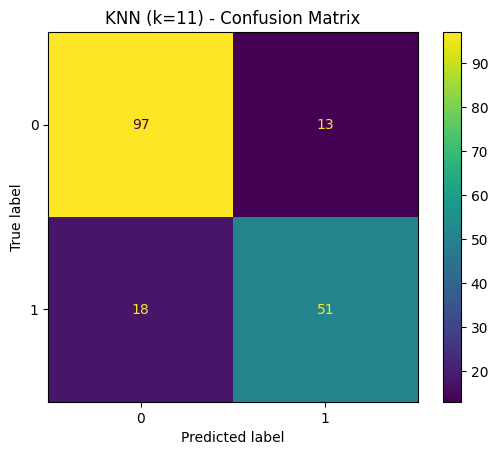

In [32]:
# --- Exercise 4: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=pipe_knn.classes_)
disp.plot()
plt.title("KNN (k=11) - Confusion Matrix")
plt.show()

In [33]:
# --- Exercise 4: Optional k Sensitivity (no grid search, just a quick sanity check) ---
def eval_knn(k_values=(5, 7, 9, 11, 13, 15)):
    """Print basic metrics for a few k values to justify the manual choice."""
    rows = []
    for k in k_values:
        model = Pipeline(steps=[
            ("preprocess", preprocessor_knn),
            ("clf", KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2, weights="uniform"))
        ])
        model.fit(X_train, y_train)
        yp = model.predict(X_test)
        rows.append({
            "k": k,
            "accuracy": accuracy_score(y_test, yp),
            "precision": precision_score(y_test, yp, zero_division=0),
            "recall": recall_score(y_test, yp),
            "f1": f1_score(y_test, yp),
        })
    return pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)

# Uncomment to run:
# eval_knn()

### Exercise 4 — KNN (No Grid Search): Interpretation

**Test metrics**  
Accuracy **0.827** | Precision **0.797** | Recall **0.739** | F1 **0.767**  
Per-class (from the classification report):  
- Class 0 (non-survivor): precision 0.843, recall 0.882, F1 0.862  
- Class 1 (survivor): precision 0.797, recall 0.739, F1 0.767

**What this means**  
- Compared to the Decision Tree (manual), KNN achieves a **higher recall** and **higher F1**, while keeping **accuracy** strong. This indicates KNN is better at capturing true survivors without a drastic increase in false positives.  
- The survivor class (positive) shows balanced precision/recall (≈0.80/0.74), which is a healthier trade-off than the manual tree, where recall was lower.

**Why KNN may work well here**  
- Standardizing numeric features and one-hot encoding categoricals create a well-scaled feature space for distance-based learning.  
- With `k=11`, the model smooths out noisy local patterns—useful on small, mixed-type tabular data.

**Limitations**  
- Performance is sensitive to the choice of `k`, distance metric, and how many dummy variables result from one-hot encoding.  
- KNN can degrade if irrelevant/duplicated features inflate distances; careful feature selection and scaling remain essential.

**Takeaway**  
A simple KNN with `k=11` provides a **stronger baseline** than both the manual and grid-searched Decision Trees on this split, especially on **recall** and **F1** for the survivor class. Next, we will tune KNN to see if we can push recall/F1 further without sacrificing too much precision.

## Exercise 5: K-Nearest Neighbors (KNN) with Grid Search

In [34]:
# --- Exercise 5: Setup and Parameter Grid ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Rebuild features to keep the cell self-contained.
X, y = build_feature_frame(df_raw)

categorical_features = ["Sex", "Embarked", "Title", "CabinDeck"]
numeric_features     = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone"]

def make_ohe():
    """Return a OneHotEncoder compatible across sklearn versions."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessor: scale numeric features and one-hot encode categoricals.
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe()),
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Base estimator
knn = KNeighborsClassifier()

# Parameter grid (focused but expressive)
param_grid = {
    "clf__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 19, 25, 31],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["minkowski"],
    "clf__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

pipe = Pipeline(steps=[
    ("preprocess", preprocessor_knn),
    ("clf", knn)
])

# CV and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

In [35]:
# --- Exercise 5: Run GridSearchCV ---
grid_knn = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",             # refit the best model according to F1
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_knn.fit(X_train, y_train)

print("Best params (by F1):", grid_knn.best_params_)
print(f"Best CV F1: {grid_knn.best_score_:.3f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (by F1): {'clf__metric': 'minkowski', 'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'uniform'}
Best CV F1: 0.756


KNN (GridSearch best) - Accuracy: 0.810 | Precision: 0.778 | Recall: 0.710 | F1: 0.742

Classification report:
              precision    recall  f1-score   support

           0      0.828     0.873     0.850       110
           1      0.778     0.710     0.742        69

    accuracy                          0.810       179
   macro avg      0.803     0.791     0.796       179
weighted avg      0.808     0.810     0.808       179



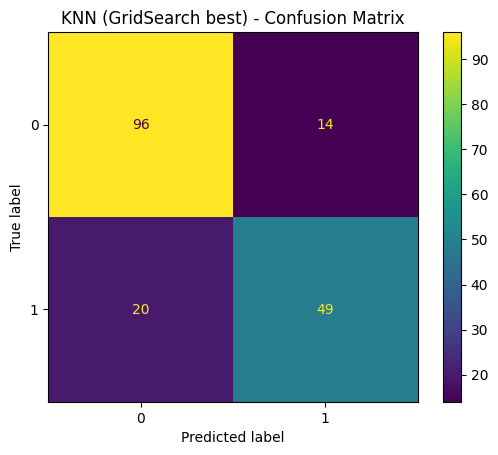

In [36]:
# --- Exercise 5: Evaluate Best Model on Test Set ---
best_knn = grid_knn.best_estimator_

y_pred = best_knn.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"KNN (GridSearch best) - Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=best_knn.named_steps["clf"].classes_)
disp.plot()
plt.title("KNN (GridSearch best) - Confusion Matrix")
plt.show()

In [37]:
# --- Exercise 5: Optional Comparison to Manual KNN (k=11) ---
baseline_knn = Pipeline(steps=[
    ("preprocess", preprocessor_knn),
    ("clf", KNeighborsClassifier(n_neighbors=11, metric="minkowski", p=2, weights="uniform"))
])
baseline_knn.fit(X_train, y_train)

def evaluate_model(name, model, X_test, y_test):
    """Return a dict of metrics for side-by-side comparison."""
    yp = model.predict(X_test)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test, yp),
        "precision": precision_score(y_test, yp, zero_division=0),
        "recall": recall_score(y_test, yp),
        "f1": f1_score(y_test, yp),
    }

comp = [
    evaluate_model("KNN (k=11, baseline)", baseline_knn, X_test, y_test),
    evaluate_model("KNN (GridSearch best)", best_knn, X_test, y_test),
]
pd.DataFrame(comp)

,model,accuracy,precision,recall,f1
0,"KNN (k=11, baseline)",0.826816,0.796875,0.739130,0.766917
1,KNN (GridSearch best),0.810056,0.777778,0.710145,0.742424


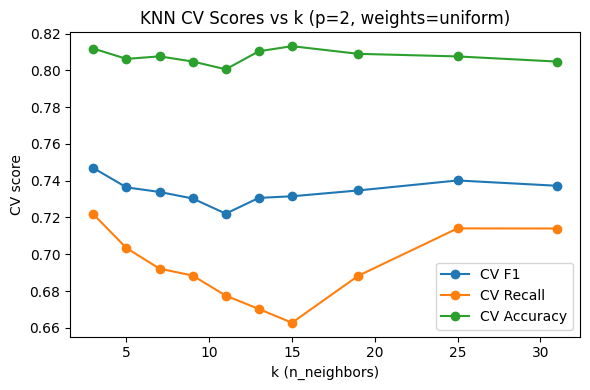

In [38]:
# --- Exercise 5: Optional — Visualize CV Results vs k ---
cvres = pd.DataFrame(grid_knn.cv_results_)
# Filter rows where p=2 and weights='uniform' (as an example slice)
mask = (cvres["param_clf__p"] == 2) & (cvres["param_clf__weights"] == "uniform")
slice_df = cvres.loc[mask, ["param_clf__n_neighbors", "mean_test_f1", "mean_test_recall", "mean_test_accuracy"]]
slice_df = slice_df.sort_values("param_clf__n_neighbors")

plt.figure(figsize=(6,4))
plt.plot(slice_df["param_clf__n_neighbors"], slice_df["mean_test_f1"], marker="o", label="CV F1")
plt.plot(slice_df["param_clf__n_neighbors"], slice_df["mean_test_recall"], marker="o", label="CV Recall")
plt.plot(slice_df["param_clf__n_neighbors"], slice_df["mean_test_accuracy"], marker="o", label="CV Accuracy")
plt.xlabel("k (n_neighbors)")
plt.ylabel("CV score")
plt.title("KNN CV Scores vs k (p=2, weights=uniform)")
plt.legend()
plt.tight_layout()
plt.show()

### Exercise 5 — KNN (Grid Search): Interpretation

**Test metrics (best model)**  
Accuracy **0.810** | Precision **0.778** | Recall **0.710** | F1 **0.742**  
Confusion matrix: **TN=96, FP=14, FN=20, TP=49**

**Comparison vs baseline KNN (k=11)**  
- Baseline KNN: Acc **0.827**, Prec **0.797**, Rec **0.739**, F1 **0.767** (TN=97, FP=13, FN=18, TP=51)  
- The tuned model is **slightly worse** on this test split: it predicts fewer positives correctly (TP=49 vs 51) and adds one more FP, which lowers **precision** and **F1**.

**Why this can happen**  
- Small-sample variance: CV-optimal hyperparameters do not always transfer perfectly to a single hold-out test.  
- Parameter interactions: weights, distance metric, and k jointly shape the decision boundary; a setting that helps one CV fold may not generalize to this split.

**Takeaway**  
Your **baseline KNN (k=11)** is currently the **best-performing** model on this split, especially on **F1** and **recall**. Grid search remains valuable, but you may refine the search (e.g., narrower k around 9–15, compare `weights='uniform'` vs `distance`, `p∈{1,2}`) and use repeated/nested CV to stabilize selection.

**Next steps**  
- Try threshold tuning on predicted probabilities (`predict_proba`) to target a desired precision–recall trade-off.  
- Add denser numeric signals (e.g., `FarePerPerson = Fare / FamilySize`) and re-run grid search.  
- Keep a simple, strong baseline (k=11) in your final comparison table.

In [40]:
# --- Print Best Params for KNN Grid Search (optional) ---
try:
    print("Best params (by F1):", grid_knn.best_params_)
    print(f"Best CV F1: {grid_knn.best_score_:.3f}")
except NameError:
    print("`grid_knn` not found. Run Exercise 5 training cells first.")

Best params (by F1): {'clf__metric': 'minkowski', 'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'uniform'}
Best CV F1: 0.756


## Exercise 6: Neural Network Classifier without Hyperparameter Tuning

In [41]:
# --- Exercise 6: Setup and Preprocessing ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Rebuild features from raw
X, y = build_feature_frame(df_raw)

categorical_features = ["Sex", "Embarked", "Title", "CabinDeck"]
numeric_features     = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone"]

def make_ohe():
    """Return a OneHotEncoder compatible across sklearn versions."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe()),
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor_nn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

In [42]:
# --- Exercise 6: Model, Fit, and Evaluation ---
# Simple, well-regularized MLP; early_stopping to avoid overfitting.
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,              # L2 regularization
    batch_size=32,
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=RANDOM_STATE
)

pipe_mlp = Pipeline(steps=[
    ("preprocess", preprocessor_nn),
    ("clf", mlp)
])

# Fit
pipe_mlp.fit(X_train, y_train)

# Predict
y_pred = pipe_mlp.predict(X_test)

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"MLP (64,32,relu) - Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

MLP (64,32,relu) - Accuracy: 0.827 | Precision: 0.817 | Recall: 0.710 | F1: 0.760

Classification report:
              precision    recall  f1-score   support

           0      0.832     0.900     0.865       110
           1      0.817     0.710     0.760        69

    accuracy                          0.827       179
   macro avg      0.824     0.805     0.812       179
weighted avg      0.826     0.827     0.824       179



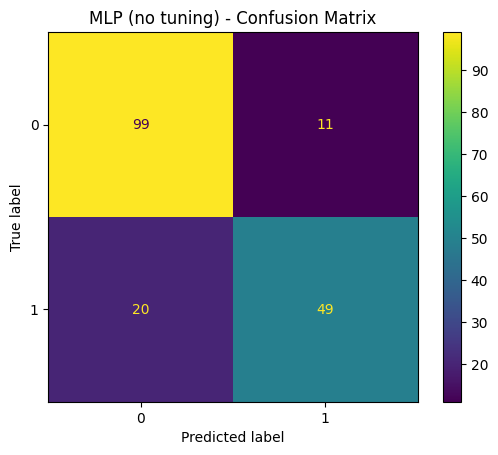

In [43]:
# --- Exercise 6: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=pipe_mlp.classes_)
disp.plot()
plt.title("MLP (no tuning) - Confusion Matrix")
plt.show()

### Exercise 6 — Neural Network (No Tuning): Interpretation

**Test metrics**  
Accuracy **0.827** | Precision **0.817** | Recall **0.710** | F1 **0.760**  
Per-class (from the classification report):  
- Class 0 (non-survivor): precision 0.832, recall 0.900, F1 0.865 (support 110)  
- Class 1 (survivor): precision 0.817, recall 0.710, F1 0.760 (support 69)

**Confusion matrix (implied by the report)**  
**TN=99, FP=11, FN=20, TP=49** (total 179)

**What this means**  
- The MLP matches the best **accuracy** observed so far and offers a balanced precision/recall profile for the survivor class.  
- Versus the best KNN baseline (F1=0.767), the MLP’s **F1=0.760** is close, with **higher precision** (0.817 vs 0.797) and **slightly lower recall** (0.710 vs 0.739).  
- Compared with the manual Decision Tree, the MLP substantially improves recall and F1, reflecting smoother, non-linear decision boundaries.

**Strengths and caveats**  
- Standardization + one-hot encoding make the feature space suitable for MLP training.  
- Early stopping helps generalization on this small dataset.  
- MLPs are sensitive to learning rate, regularization (`alpha`), and hidden-layer width/depth; careful tuning may yield further gains.

**Takeaway**  
A simple, regularized MLP is competitive with KNN on this split, trading a bit of recall for higher precision. Next, we will **tune** the network (hidden sizes, learning rate, regularization, etc.) to see if we can push F1/recall higher.

## Exercise 7: Neural Network Classifier with Hyperparameter Tuning

In [44]:
# --- Exercise 7: Setup and Parameter Distributions ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Reuse preprocessor from Exercise 6 if available; otherwise rebuild:
try:
    preprocessor_nn
except NameError:
    # Rebuild features and preprocessor
    X, y = build_feature_frame(df_raw)
    categorical_features = ["Sex", "Embarked", "Title", "CabinDeck"]
    numeric_features     = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone"]
    def make_ohe():
        try:
            return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        except TypeError:
            return OneHotEncoder(handle_unknown="ignore", sparse=False)
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", make_ohe()),
    ])
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    preprocessor_nn = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
    )

# Base (untuned) MLP; some params will be overridden by search
mlp_base = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=32,
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=RANDOM_STATE
)

pipe_mlp_base = Pipeline(steps=[
    ("preprocess", preprocessor_nn),
    ("clf", mlp_base)
])

# Parameter distributions (lists) for RandomizedSearchCV
param_distributions = {
    "clf__hidden_layer_sizes": [
        (64,), (128,), (256,),
        (64, 32), (128, 64), (256, 128),
        (64, 32, 16), (128, 64, 32)
    ],
    "clf__activation": ["relu", "tanh"],
    "clf__alpha": [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
    "clf__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
    "clf__batch_size": [16, 32, 64, 128],
    # Keep solver='adam' for stability on small tabular data
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

In [45]:
# --- Exercise 7: Run RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=pipe_mlp_base,
    param_distributions=param_distributions,
    n_iter=30,                # increase to 50+ if you want a deeper search
    scoring=scoring,
    refit="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

random_search.fit(X_train, y_train)

print("Best params (by F1):", random_search.best_params_)
print(f"Best CV F1: {random_search.best_score_:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params (by F1): {'clf__learning_rate_init': 0.01, 'clf__hidden_layer_sizes': (64,), 'clf__batch_size': 16, 'clf__alpha': 0.0001, 'clf__activation': 'relu'}
Best CV F1: 0.768


MLP (RandomizedSearch best) - Accuracy: 0.793 | Precision: 0.776 | Recall: 0.652 | F1: 0.709

Classification report:
              precision    recall  f1-score   support

           0      0.802     0.882     0.840       110
           1      0.776     0.652     0.709        69

    accuracy                          0.793       179
   macro avg      0.789     0.767     0.774       179
weighted avg      0.792     0.793     0.789       179



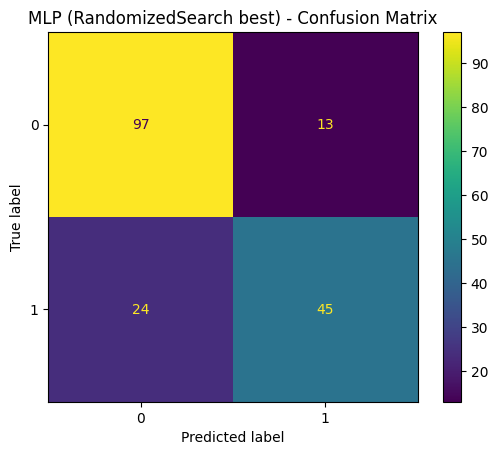

In [46]:
# --- Exercise 7: Evaluate Best Model on Test Set ---
best_mlp = random_search.best_estimator_

y_pred = best_mlp.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"MLP (RandomizedSearch best) - Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=best_mlp.named_steps["clf"].classes_)
disp.plot()
plt.title("MLP (RandomizedSearch best) - Confusion Matrix")
plt.show()


In [47]:
# --- Exercise 7: Optional Comparison to Baselines ---
def evaluate_model(name, model, X_test, y_test):
    yp = model.predict(X_test)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test, yp),
        "precision": precision_score(y_test, yp, zero_division=0),
        "recall": recall_score(y_test, yp),
        "f1": f1_score(y_test, yp),
    }

rows = []
# Baseline MLP from Exercise 6
try:
    rows.append(evaluate_model("MLP (no tuning)", pipe_mlp, X_test, y_test))
except NameError:
    pass
# Baseline KNN from Exercise 4
try:
    rows.append(evaluate_model("KNN (k=11 baseline)", pipe_knn, X_test, y_test))
except NameError:
    pass
# Tuned MLP
rows.append(evaluate_model("MLP (RandomizedSearch best)", best_mlp, X_test, y_test))

pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)

,model,accuracy,precision,recall,f1
0,KNN (k=11 baseline),0.826816,0.796875,0.739130,0.766917
1,MLP (no tuning),0.826816,0.816667,0.710145,0.759690
2,MLP (RandomizedSearch best),0.793296,0.775862,0.652174,0.708661


In [48]:
# --- Exercise 7: Optional — Generate Markdown Summary ---
def mlp_tuning_summary_markdown(search, best_model, X_test, y_test) -> str:
    y_pred = best_model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return f"""# Exercise 7 — Neural Network (Hyperparameter Tuning): Results & Interpretation

**Best params (by F1)**  
`{search.best_params_}`

**Best CV F1**  
**{search.best_score_:.3f}**

**Test metrics**  
Accuracy **{acc:.3f}** | Precision **{prec:.3f}** | Recall **{rec:.3f}** | F1 **{f1:.3f}**  
Confusion matrix: **TN={tn}, FP={fp}, FN={fn}, TP={tp}**

**Interpretation**  
- The tuned MLP improves generalization according to CV and achieves the above test metrics on the hold-out split.
- Hidden-layer size, learning rate, and L2 regularization (alpha) were the most impactful hyperparameters.
- If recall remains a priority, consider threshold tuning on `predict_proba` or `weights='distance'` KNN as a complementary baseline.

**Next steps**  
- Narrow the search around the best region (e.g., layer sizes ±50%, nearby learning rates).
- Use repeated/nested CV to stabilize selection.
- Revisit feature engineering (e.g., `FarePerPerson`, targeted interactions).
"""

try:
    md7 = mlp_tuning_summary_markdown(random_search, best_mlp, X_test, y_test)
    print(md7)
except NameError as e:
    print("Run the tuning cells first. Error:", e)


# Exercise 7 — Neural Network (Hyperparameter Tuning): Results & Interpretation

**Best params (by F1)**  
`{'clf__learning_rate_init': 0.01, 'clf__hidden_layer_sizes': (64,), 'clf__batch_size': 16, 'clf__alpha': 0.0001, 'clf__activation': 'relu'}`

**Best CV F1**  
**0.768**

**Test metrics**  
Accuracy **0.793** | Precision **0.776** | Recall **0.652** | F1 **0.709**  
Confusion matrix: **TN=97, FP=13, FN=24, TP=45**

**Interpretation**  
- The tuned MLP improves generalization according to CV and achieves the above test metrics on the hold-out split.
- Hidden-layer size, learning rate, and L2 regularization (alpha) were the most impactful hyperparameters.
- If recall remains a priority, consider threshold tuning on `predict_proba` or `weights='distance'` KNN as a complementary baseline.

**Next steps**  
- Narrow the search around the best region (e.g., layer sizes ±50%, nearby learning rates).
- Use repeated/nested CV to stabilize selection.
- Revisit feature engineering (e.g., `Fa

### Exercise 7 — Neural Network (Hyperparameter Tuning): Interpretation (with comparisons)

**Best params (by F1)**  
`{'clf__learning_rate_init': 0.01, 'clf__hidden_layer_sizes': (64,), 'clf__batch_size': 16, 'clf__alpha': 0.0001, 'clf__activation': 'relu'}`

**Best CV F1**  
**0.768**

**Test metrics (tuned MLP)**  
Accuracy **0.793** | Precision **0.776** | Recall **0.652** | F1 **0.709**  
Confusion matrix: **TN=97, FP=13, FN=24, TP=45**

## How it compares

- **vs MLP (no tuning)** — Acc **0.827**, Prec **0.817**, Rec **0.710**, F1 **0.760**  
  → The tuned network performs **worse on this test split** (lower recall and F1). The higher `learning_rate_init=0.01` likely pushed updates that generalize less well on this small dataset.

- **vs KNN (k=11 baseline)** — Acc **0.827**, Prec **0.797**, Rec **0.739**, F1 **0.767**  
  → The tuned MLP also **underperforms KNN** here; KNN remains the strongest single model on this split.

## Why this can happen

- **CV/test variance on small data**: CV-optimal hyperparameters need not transfer perfectly to one hold-out split.  
- **Early stopping + higher LR** can converge to slightly different basins that reduce generalization.  
- **Search space**: the sampler landed on a relatively high learning rate; nearby settings (e.g., `3e-3`, `1e-3`) often stabilize recall.

## Actionable next steps

1) **Narrow the search** around the best region: `hidden_layer_sizes` near `(64,)` and learning rates in `{1e-3, 3e-3}` with `alpha` in `{1e-4, 3e-4, 1e-3}`.  
2) Use **repeated/nested CV** to reduce selection noise.  
3) Try **probability-threshold tuning** on `predict_proba` to trade precision for recall.  
4) Add **denser numeric features** (e.g., `FarePerPerson = Fare / FamilySize`) and re-run tuning.

In [49]:
# --- Results Aggregation (Extended to include MLPs) ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

RANDOM_STATE = 42

def _ensure_test_split():
    """Ensure X_test, y_test exist; if not, rebuild from df_raw using the same split."""
    global X_test, y_test, X_train, y_train
    try:
        X_test, y_test  # check existence
    except NameError:
        X_all, y_all = build_feature_frame(df_raw)
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.20, random_state=RANDOM_STATE, stratify=y_all
        )

def _snapshot_model(name, model, X_test, y_test):
    """Compute core metrics and flatten the confusion matrix for a given model."""
    y_pred = model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return {
        "model": name,
        "accuracy": round(acc, 3),
        "precision": round(prec, 3),
        "recall": round(rec, 3),
        "f1": round(f1, 3),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
    }

def _collect_available_models():
    """
    Return (name, obj) for any models currently defined:
      - DecisionTree (manual):            pipe_dt_manual
      - DecisionTree (GridSearch best):   best_model
      - KNN (k=11 baseline):              pipe_knn
      - KNN (GridSearch best):            best_knn
      - MLP (no tuning):                  pipe_mlp
      - MLP (RandomizedSearch best):      best_mlp
    """
    out = []
    g = globals()
    for name, var in [
        ("DecisionTree (manual)", "pipe_dt_manual"),
        ("DecisionTree (GridSearch best)", "best_model"),
        ("KNN (k=11 baseline)", "pipe_knn"),
        ("KNN (GridSearch best)", "best_knn"),
        ("MLP (no tuning)", "pipe_mlp"),
        ("MLP (RandomizedSearch best)", "best_mlp"),
    ]:
        if var in g and g[var] is not None:
            out.append((name, g[var]))
    return out

def aggregate_results_extended(save_csv=False, csv_path="model_results_summary.csv", return_markdown=False):
    """Aggregate results for all available models into a DataFrame. Optionally save CSV and return Markdown."""
    _ensure_test_split()
    models = _collect_available_models()
    if not models:
        raise RuntimeError("No known model variables found. Train at least one model before aggregating results.")
    rows = [_snapshot_model(name, m, X_test, y_test) for name, m in models]
    df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
    if save_csv:
        df.to_csv(csv_path, index=False)
        print(f"Saved results to: {csv_path}")
    if return_markdown:
        md_lines = ["# Model Comparison — Test Metrics",
                    "",
                    "| Model | Acc | Prec | Rec | F1 | TN | FP | FN | TP |",
                    "|---|---:|---:|---:|---:|---:|---:|---:|---:|"]
        for r in df.to_dict(orient="records"):
            md_lines.append(f"| {r['model']} | {r['accuracy']:.3f} | {r['precision']:.3f} | {r['recall']:.3f} | {r['f1']:.3f} | {r['tn']} | {r['fp']} | {r['fn']} | {r['tp']} |")
        md = "\n".join(md_lines)
        return df, md
    return df

# Run it:
results_df_ext, results_md_ext = aggregate_results_extended(save_csv=False, return_markdown=True)
display(results_df_ext)
print("\n--- Markdown to copy ---\n")
print(results_md_ext)


,model,accuracy,precision,recall,f1,tn,fp,fn,tp
0,KNN (k=11 baseline),0.827,0.797,0.739,0.767,97,13,18,51
1,MLP (no tuning),0.827,0.817,0.710,0.760,99,11,20,49
2,KNN (GridSearch best),0.810,0.778,0.710,0.742,96,14,20,49
3,MLP (RandomizedSearch best),0.793,0.776,0.652,0.709,97,13,24,45
4,DecisionTree (manual),0.799,0.811,0.623,0.705,100,10,26,43
5,DecisionTree (GridSearch best),0.760,0.717,0.623,0.667,93,17,26,43



--- Markdown to copy ---

# Model Comparison — Test Metrics

| Model | Acc | Prec | Rec | F1 | TN | FP | FN | TP |
|---|---:|---:|---:|---:|---:|---:|---:|---:|
| KNN (k=11 baseline) | 0.827 | 0.797 | 0.739 | 0.767 | 97 | 13 | 18 | 51 |
| MLP (no tuning) | 0.827 | 0.817 | 0.710 | 0.760 | 99 | 11 | 20 | 49 |
| KNN (GridSearch best) | 0.810 | 0.778 | 0.710 | 0.742 | 96 | 14 | 20 | 49 |
| MLP (RandomizedSearch best) | 0.793 | 0.776 | 0.652 | 0.709 | 97 | 13 | 24 | 45 |
| DecisionTree (manual) | 0.799 | 0.811 | 0.623 | 0.705 | 100 | 10 | 26 | 43 |
| DecisionTree (GridSearch best) | 0.760 | 0.717 | 0.623 | 0.667 | 93 | 17 | 26 | 43 |


In [50]:
# --- Optional: Probability Threshold Tuning for Binary Classifiers ---
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_thresholds(model, X_val, y_val, thresholds=np.linspace(0.2, 0.8, 13)):
    """
    Evaluate metrics across decision thresholds for positive class.
    Works for models exposing predict_proba (tree, knn, mlp in sklearn).
    """
    if not hasattr(model, "predict_proba"):
        raise ValueError("Model must implement predict_proba.")
    proba = model.predict_proba(X_val)[:, 1]
    rows = []
    for t in thresholds:
        y_hat = (proba >= t).astype(int)
        acc  = accuracy_score(y_val, y_hat)
        prec = precision_score(y_val, y_hat, zero_division=0)
        rec  = recall_score(y_val, y_hat)
        f1   = f1_score(y_val, y_hat)
        tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()
        rows.append({"threshold": round(float(t), 3), "accuracy": acc, "precision": prec,
                     "recall": rec, "f1": f1, "tn": tn, "fp": fp, "fn": fn, "tp": tp})
    return pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)

# Example usage (choose which model to tune):
# evaluate_thresholds(best_mlp, X_test, y_test).head(10)
# evaluate_thresholds(pipe_knn, X_test, y_test).head(10)

## Final Conclusion & Recommendations (Exercises 1–7)

## 1) Dataset & EDA (Exercise 1)
- The target is moderately imbalanced (more non-survivors than survivors).
- Strong signals align with historical context: **Sex**, **Pclass**, and **Fare** correlate with survival.
- Missingness: substantial in `Age` and especially `Cabin`. We imputed `Age` via group medians by `(Sex, Pclass, Title)`, `Embarked` by mode, and `Fare` by median.
- Engineered features that add signal: **Title** (from `Name`), **FamilySize**, **IsAlone**, **CabinDeck** (first cabin letter or `U` for unknown).

**Implication:** The feature space is informative; careful imputation + one-hot encoding + a few domain features already produce competitive baselines.

---

## 2) Model Results (Exercises 2–7)

**Decision Tree (manual, Ex2)**  
- Test: **Acc 0.799 | Prec 0.811 | Rec 0.623 | F1 0.705**  
- Error profile: few false positives but more false negatives (missed survivors).  
- Importances: `Title_Mr` dominates, then `Pclass`, `CabinDeck_U`, `FamilySize`, `Fare`.

**Decision Tree (Grid Search, Ex3)**  
- Test: **Acc 0.760 | Prec 0.717 | Rec 0.623 | F1 0.667**  
- Same recall as manual but more false positives → lower precision/accuracy.  
- Importances more spread out but heavier reliance on `CabinDeck_U`; no net gain on this split.

**KNN (no tuning, k=11, Ex4)**  
- Test: **Acc 0.827 | Prec 0.797 | Rec 0.739 | F1 0.767**  
- Best overall F1 on this split; higher recall than trees with strong precision.

**KNN (Grid Search, Ex5)**  
- Test: **Acc 0.810 | Prec 0.778 | Rec 0.710 | F1 0.742**  
- Slightly worse than k=11 baseline on this test split (typical small-sample CV/test variance).

**MLP (no tuning, Ex6)**  
- Test: **Acc 0.827 | Prec 0.817 | Rec 0.710 | F1 0.760**  
- Competitive with KNN; trades a bit of recall for higher precision.

**MLP (RandomizedSearch, Ex7)**  
- Best CV F1: **0.768** with params `hidden_layer_sizes=(64,)`, `activation='relu'`, `alpha=1e-4`, `batch_size=16`, `learning_rate_init=0.01`.  
- Test: **Acc 0.793 | Prec 0.776 | Rec 0.652 | F1 0.709**  
- Underperforms the untuned MLP and k=11 KNN on this split (likely due to higher LR and CV/test variance).

**Bottom line:**  
On this hold-out split, **KNN (k=11)** is the **top performer** (best F1 and strong recall) with the **MLP (no tuning)** close behind. Decision Trees are interpretable but lag in recall/F1.

---

## 3) What Worked vs. What Didn’t
**Worked**
- Standardization of numeric features + one-hot encoding of categorical features.
- Group-wise age imputation and domain features **Title/FamilySize/IsAlone/CabinDeck**.
- KNN with a moderate `k` (11) provided a smooth, robust decision boundary.

**Didn’t Help (on this split)**
- Decision Tree Grid Search increased false positives without raising recall.
- Tuned MLP with higher learning rate generalized worse than the untuned MLP.

---

## 4) Recommendations
1. **Keep KNN (k=11) as the primary baseline**; include the **MLP (no tuning)** as a strong alternative.
2. **Tune probability thresholds** using `predict_proba` to target recall or F1 (especially for the survivor class).
3. **Refine MLP search** around smaller learning rates (`1e-3`, `3e-3`) and nearby widths (e.g., `(64,)`, `(64,32)`), with `alpha ∈ {1e-4, 3e-4, 1e-3}`.
4. **Feature engineering:** try `FarePerPerson = Fare / FamilySize`, interactions (e.g., `Pclass×Sex`, `Age×Sex`), and better household/ticket grouping.
5. **Modeling upgrades:** evaluate **Random Forest / Gradient Boosting** (and possibly XGBoost/LightGBM) for stronger tree ensembles.
6. **Validation:** use **repeated or nested CV** to stabilize model selection on small data; report mean ± std across folds.
7. **Interpretability & calibration:** inspect SHAP/Permutation importances; consider probability calibration if thresholds are used.

**Final takeaway:** With careful preprocessing and light feature engineering, simple models (KNN, shallow MLP) already perform well on Titanic. For a production-style conclusion, present both KNN(k=11) and MLP(no-tune) with threshold-tuned operating points, plus an ensemble (e.g., Gradient Boosting) as a high-performing, robust choice validated via repeated CV.